Prepare files for comparing allele-wise AUCs from the first single model to those from CLAIRE

In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict
from collections import Counter

from sklearn import metrics

import pickle

import matplotlib.pyplot as plt

import math

### DePTH HLA-I full mcpas performance

In [4]:
test_neg_score_file = "HLA_I_full_mcpas_neg_test_5779_7821_6367/predicted_scores.csv"
test_pos_score_file = "HLA_I_full_mcpas_pos_test_5779_7821_6367/predicted_scores.csv"

df_test_neg_scores = pd.read_csv("../results/predicted_scores/HLA_I_full_mcpas_ensemble/"+test_neg_score_file, 
                                 header = 0)
df_test_pos_scores = pd.read_csv("../results/predicted_scores/HLA_I_full_mcpas_ensemble/"+test_pos_score_file, 
                                 header = 0)

print(df_test_neg_scores.shape)
print(df_test_pos_scores.shape)

(1041, 3)
(1045, 3)


In [5]:
df_test_neg_scores[:6]

,tcr,hla_allele,score
0,"TRBV7-2*01,CASSSSQGNQPQHF",HLA-A*02:01,0.127530
1,"TRBV30*01,CAWEKGTSGTYEQYF",HLA-A*11:01,0.136442
2,"TRBV27*01,CASKQGAGGLYEQYF",HLA-C*07:02,0.204902
3,"TRBV7-9*01,CASSPQGINTEAFF",HLA-C*07:02,0.078044
4,"TRBV20-1*01,CSARSYSGSSYNEQFF",HLA-A*02:01,0.893703
5,"TRBV12-4*01,CASSLGRELAEAF",HLA-A*02:01,0.393354


In [7]:
pos_scores = df_test_pos_scores.score.tolist()
neg_scores = df_test_neg_scores.score.tolist()

test_y = [0 for _ in range(df_test_neg_scores.shape[0])] + [1 for _ in range(df_test_pos_scores.shape[0])]
test_pred = neg_scores + pos_scores

fpr, tpr, thresholds = metrics.roc_curve(test_y, test_pred, pos_label=1)
print("AUC ", round(metrics.auc(fpr, tpr), 2))
print("recall ", round(sum([x>0.5 for x in pos_scores])/len(pos_scores), 2))
print("precision ", round(sum([x<=0.5 for x in neg_scores])/len(neg_scores), 2))

AUC  0.76
recall  0.65
precision  0.71


In [8]:
HLA_I_2_compare = list(set(df_test_neg_scores.hla_allele.tolist() + df_test_pos_scores.hla_allele.tolist()))
HLA_I_2_compare.sort()
HLA_I_2_compare

['HLA-A*01:01',
 'HLA-A*02:01',
 'HLA-A*02:05',
 'HLA-A*02:06',
 'HLA-A*11:01',
 'HLA-A*24:02',
 'HLA-B*07:02',
 'HLA-B*08:01',
 'HLA-B*14:01',
 'HLA-B*27:05',
 'HLA-B*35:01',
 'HLA-B*35:02',
 'HLA-B*57:01',
 'HLA-C*07:02',
 'HLA-C*16:01']

In [10]:
# compute allele-wise AUCs, only for HLA-I alleles with both positive and negative pairs in test data

DePTH_aucs_dict = defaultdict(float)

for cur_hla in HLA_I_2_compare:
    
    cur_test_neg_scores = [y for x, y in zip(df_test_neg_scores.hla_allele.tolist(), 
                                             df_test_neg_scores.score.tolist()) if x == cur_hla]
    cur_test_pos_scores = [y for x, y in zip(df_test_pos_scores.hla_allele.tolist(), 
                                             df_test_pos_scores.score.tolist()) if x == cur_hla]

    cur_labels = [0 for _ in range(len(cur_test_neg_scores))] + [1 for _ in range(len(cur_test_pos_scores))]
    cur_scores = cur_test_neg_scores + cur_test_pos_scores

    if len(set(cur_labels)) > 1:
        fpr, tpr, thresholds = metrics.roc_curve(cur_labels, cur_scores, pos_label=1)
        DePTH_aucs_dict[cur_hla] = metrics.auc(fpr, tpr)
    else:
        DePTH_aucs_dict[cur_hla] = np.nan

In [11]:
DePTH_aucs_dict

defaultdict(float,
            {'HLA-A*01:01': 0.6338518690503832,
             'HLA-A*02:01': 0.7576686354054807,
             'HLA-A*02:05': nan,
             'HLA-A*02:06': nan,
             'HLA-A*11:01': 0.7326007326007327,
             'HLA-A*24:02': 0.7023809523809524,
             'HLA-B*07:02': 0.7235591206179441,
             'HLA-B*08:01': 0.7548717948717949,
             'HLA-B*14:01': nan,
             'HLA-B*27:05': 0.7118055555555556,
             'HLA-B*35:01': 1.0,
             'HLA-B*35:02': nan,
             'HLA-B*57:01': 0.93,
             'HLA-C*07:02': 0.8470492470492471,
             'HLA-C*16:01': nan})

### CLAIRE performance on mcpas

In [12]:
# load predicted scores
df_Glazer_2022_test_pos_scores = pd.read_csv("../results/CLAIRE_mcpas/st2_Glazer_2022_test_pos_scores.csv", header = 0)
df_Glazer_2022_test_neg_scores = pd.read_csv("../results/CLAIRE_mcpas/st2_Glazer_2022_test_neg_scores.csv", header = 0)

In [14]:
print(df_Glazer_2022_test_pos_scores.shape)
print(df_Glazer_2022_test_neg_scores.shape)

(1620, 10)
(1639, 10)


In [15]:
y = np.array([1 for _ in range(df_Glazer_2022_test_pos_scores.shape[0])] + 
             [0 for _ in range(df_Glazer_2022_test_neg_scores.shape[0])])

pred = np.array(df_Glazer_2022_test_pos_scores.prediction.tolist() + 
                df_Glazer_2022_test_neg_scores.prediction.tolist())

fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.7120585045081689

In [16]:
# allele-wise AUC from CLAIRE on HLA-A02:01

hlaa0201_pos_scores = [p for p, hla in zip(df_Glazer_2022_test_pos_scores.prediction.tolist(), 
                                           df_Glazer_2022_test_pos_scores.mhc.tolist()) if hla == "HLA-A02:01"]

hlaa0201_neg_scores = [p for p, hla in zip(df_Glazer_2022_test_neg_scores.prediction.tolist(), 
                                           df_Glazer_2022_test_neg_scores.mhc.tolist()) if hla == "HLA-A02:01"]

y = np.array([1 for _ in range(len(hlaa0201_pos_scores))] + 
             [0 for _ in range(len(hlaa0201_neg_scores))])

pred = np.array(hlaa0201_pos_scores + hlaa0201_neg_scores)

fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.8727031380503518

In [17]:
# allele-wise AUC from CLAIRE on HLA-B07:01

hlab0701_pos_scores = [p for p, hla in zip(df_Glazer_2022_test_pos_scores.prediction.tolist(), 
                                           df_Glazer_2022_test_pos_scores.mhc.tolist()) if hla == "HLA-B07:01"]

hlab0701_neg_scores = [p for p, hla in zip(df_Glazer_2022_test_neg_scores.prediction.tolist(), 
                                           df_Glazer_2022_test_neg_scores.mhc.tolist()) if hla == "HLA-B07:01"]

y = np.array([1 for _ in range(len(hlab0701_pos_scores))] + 
             [0 for _ in range(len(hlab0701_neg_scores))])

pred = np.array(hlab0701_pos_scores + hlab0701_neg_scores)

fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.6571443529247523

In [18]:
# allele-wise AUC from CLAIRE on HLA-A01:01

hlaa0101_pos_scores = [p for p, hla in zip(df_Glazer_2022_test_pos_scores.prediction.tolist(), 
                                           df_Glazer_2022_test_pos_scores.mhc.tolist()) if hla == "HLA-A01:01"]

hlaa0101_neg_scores = [p for p, hla in zip(df_Glazer_2022_test_neg_scores.prediction.tolist(), 
                                           df_Glazer_2022_test_neg_scores.mhc.tolist()) if hla == "HLA-A01:01"]

y = np.array([1 for _ in range(len(hlaa0101_pos_scores))] + 
             [0 for _ in range(len(hlaa0101_neg_scores))])

pred = np.array(hlaa0101_pos_scores + hlaa0101_neg_scores)

fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.5135825400510796

In [19]:
# transform the 15 HLA-I alleles that we have pseudo sequences for into the format of CLAIRE mcpas data
hlas_kept = set(["".join(x.split("*")) for x in HLA_I_2_compare])

In [20]:
hla_kept_pos_scores = [p for p, hla in zip(df_Glazer_2022_test_pos_scores.prediction.tolist(), 
                                           df_Glazer_2022_test_pos_scores.mhc.tolist()) if hla in hlas_kept]

hla_kept_neg_scores = [p for p, hla in zip(df_Glazer_2022_test_neg_scores.prediction.tolist(), 
                                           df_Glazer_2022_test_neg_scores.mhc.tolist()) if hla in hlas_kept]

y = np.array([1 for _ in range(len(hla_kept_pos_scores))] + 
             [0 for _ in range(len(hla_kept_neg_scores))])

pred = np.array(hla_kept_pos_scores + hla_kept_neg_scores)

fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.7775620607715253

In [21]:
print(len(hla_kept_pos_scores))
print(len(hla_kept_neg_scores))

1045
1041


In [22]:
Counter(df_Glazer_2022_test_pos_scores.mhc.tolist() + 
        df_Glazer_2022_test_neg_scores.mhc.tolist())

Counter({'HLA-B07:02': 168,
         'HLA-A02:01': 1274,
         'HLA-DR01:04': 146,
         'HLA-B07:01': 681,
         'HLA-A01:01': 132,
         'HLA-DQ08:01': 6,
         'HLA-C07:02': 222,
         'HLA-B08:01': 110,
         'HLA-B27:05': 34,
         'HLA-B42:01': 105,
         'HLA-B57:03': 28,
         'HLA-A24:02': 66,
         'HLA-B35:01': 16,
         'HLA-DR15:01': 39,
         'HLA-DR11:01': 29,
         'HLA-A02:06': 1,
         'HLA-B57:01': 25,
         'HLA-A11:01': 34,
         'HLA-DR05:01': 23,
         'HLA-DQ02:01': 50,
         'HLA-DR01:15': 4,
         'HLA-DQ01:06': 25,
         'HLA-B27:01': 5,
         'HLA-DR01:01': 21,
         'HLA-A02:10': 1,
         'HLA-DR04:01': 1,
         'HLA-A02:13': 1,
         'HLA-DQ02:05': 5,
         'HLA-B35:02': 1,
         'HLA-A02:07': 1,
         'HLA-A02:05': 1,
         'HLA-B14:01': 1,
         'HLA-A02:04': 1,
         'HLA-C16:01': 1,
         'HLA-DQ01:01': 1})

In [23]:
# convert DePTH_aucs_dict to the format as for CLAIRE mcpas
# remove the HLAs with no positive pair or with no negative pair

DePTH_aucs_mcpas_format_dict = defaultdict(float)

DePTH_aucs_dict_keys = list(DePTH_aucs_dict.keys())

allele_wise_compare_list = []


for key in DePTH_aucs_dict_keys:
    
    if DePTH_aucs_dict[key] == DePTH_aucs_dict[key]:
        
        mcpas_key = "".join(key.split("*"))
        allele_wise_compare_list += [mcpas_key]
        DePTH_aucs_mcpas_format_dict[mcpas_key] = DePTH_aucs_dict[key]
        
print(allele_wise_compare_list)
DePTH_aucs_mcpas_format_dict

['HLA-A01:01', 'HLA-A02:01', 'HLA-A11:01', 'HLA-A24:02', 'HLA-B07:02', 'HLA-B08:01', 'HLA-B27:05', 'HLA-B35:01', 'HLA-B57:01', 'HLA-C07:02']


defaultdict(float,
            {'HLA-A01:01': 0.6338518690503832,
             'HLA-A02:01': 0.7576686354054807,
             'HLA-A11:01': 0.7326007326007327,
             'HLA-A24:02': 0.7023809523809524,
             'HLA-B07:02': 0.7235591206179441,
             'HLA-B08:01': 0.7548717948717949,
             'HLA-B27:05': 0.7118055555555556,
             'HLA-B35:01': 1.0,
             'HLA-B57:01': 0.93,
             'HLA-C07:02': 0.8470492470492471})

In [24]:
# define a function to compute allele-wise AUC from CLAIRE mcpas predicted scores

def allelewise_auc(cur_hla):
    
    cur_pos_scores = [p for p, hla in zip(df_Glazer_2022_test_pos_scores.prediction.tolist(), 
                                          df_Glazer_2022_test_pos_scores.mhc.tolist()) if hla == cur_hla]

    cur_neg_scores = [p for p, hla in zip(df_Glazer_2022_test_neg_scores.prediction.tolist(), 
                                          df_Glazer_2022_test_neg_scores.mhc.tolist()) if hla == cur_hla]
    
    if ((len(cur_pos_scores) == 0) or (len(cur_neg_scores) == 0)):
        
        return np.nan
        
    else:

        y = np.array([1 for _ in range(len(cur_pos_scores))] + 
                     [0 for _ in range(len(cur_neg_scores))])

        pred = np.array(cur_pos_scores + cur_neg_scores)

        fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
        return(metrics.auc(fpr, tpr))


In [25]:
Glazer_2022_allelewise_dict = defaultdict(float)

for cur_hla in allele_wise_compare_list:
    Glazer_2022_allelewise_dict[cur_hla] = allelewise_auc(cur_hla)
    
Glazer_2022_allelewise_dict

defaultdict(float,
            {'HLA-A01:01': 0.5135825400510796,
             'HLA-A02:01': 0.8727031380503518,
             'HLA-A11:01': 0.4505494505494506,
             'HLA-A24:02': 0.6448412698412698,
             'HLA-B07:02': 0.5570409982174688,
             'HLA-B08:01': 0.4704273504273504,
             'HLA-B27:05': 0.3194444444444445,
             'HLA-B35:01': 0.8571428571428572,
             'HLA-B57:01': 0.52,
             'HLA-C07:02': 0.6127798127798127})

In [27]:
Glazer_2022_allelewise_list = [Glazer_2022_allelewise_dict[hla] for hla in allele_wise_compare_list]
DePTH_McPAS_allelewise_list = [DePTH_aucs_mcpas_format_dict[hla] for hla in allele_wise_compare_list]

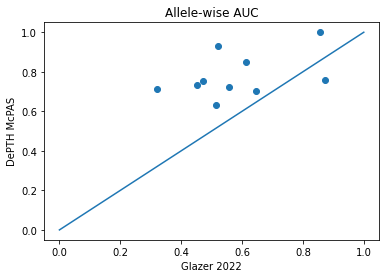

In [28]:
plt.scatter(Glazer_2022_allelewise_list, DePTH_McPAS_allelewise_list)
plt.plot([0.0, 1.0])
plt.title('Allele-wise AUC')
plt.xlabel('Glazer 2022')
plt.ylabel('DePTH McPAS')
plt.show()

In [29]:
# save the AUCs out, for generating plots in the paper

hlas_to_compare_star = [x[:5]+"*"+x[5:] for x in allele_wise_compare_list]

df_allelewise_auc = pd.DataFrame(list(zip(hlas_to_compare_star, 
                                          DePTH_McPAS_allelewise_list, 
                                          Glazer_2022_allelewise_list)), 
                                 columns = ["hla", "depth_mcpas", "glazer_server"])

In [30]:
df_allelewise_auc

,hla,depth_mcpas,glazer_server
0,HLA-A*01:01,0.633852,0.513583
1,HLA-A*02:01,0.757669,0.872703
2,HLA-A*11:01,0.732601,0.450549
3,HLA-A*24:02,0.702381,0.644841
4,HLA-B*07:02,0.723559,0.557041
5,HLA-B*08:01,0.754872,0.470427
6,HLA-B*27:05,0.711806,0.319444
7,HLA-B*35:01,1.000000,0.857143
8,HLA-B*57:01,0.930000,0.520000
9,HLA-C*07:02,0.847049,0.612780


In [32]:
df_allelewise_auc.to_csv("../results/st14_allelewise_auc_single.csv", index = False)